In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [9]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt

In [10]:
dataset_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/data/'
training_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/data/train/'
validation_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/data/val/'
test_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/data/test/'
model_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/resnet_152v2_model.h5'

IMAGE_SIZE = [224, 224,3]
EPOCHS = 30
TARGET_SIZE = (224,224)
BATCH_SIZE = 16

In [11]:
# useful for getting number of output classes
folders = glob(training_path+'*')
print(len(folders))

4


In [13]:
# importing the resnet and using the imagenet weights
# Here we will be using imagenet weights

resnet_152 = ResNet152V2(include_top=False,weights='imagenet',input_shape=IMAGE_SIZE)

In [14]:
# don't train existing weights
for layer in resnet_152.layers:
  layer.trainable = False

In [15]:
# our layers - you can add more if you want
x_network = Flatten()(resnet_152.output)
# adding the prediction layer
prediction_layer = Dense(len(folders),activation='softmax')(x_network)

In [16]:
# create a model object
model = Model(inputs = resnet_152.input , outputs = prediction_layer)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [17]:
# compiling the model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [18]:
# creating callbacks to save best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= model_path,
                                                               save_weights_only='False',
                                                               monitor='val_accuracy',
                                                               save_best_only=True)


In [19]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = None):
    k = list(logs.keys())
    # print(k)
    if(logs.get('val_accuracy') > 0.99):
      print('Required accuracy reached , so stopping training.....!!')
      self.model.stop_training = True
  

In [20]:
# creating datagenerators

# train datagenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# test datagenerator
test_datagen = ImageDataGenerator(rescale= 1./255)

In [21]:
training_data = train_datagen.flow_from_directory(training_path,
                                                  target_size = TARGET_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = 'categorical')

validation_dataset = test_datagen.flow_from_directory(validation_path,
                                                   target_size = TARGET_SIZE,
                                                   batch_size = BATCH_SIZE,
                                                   class_mode = 'categorical')

Found 1951 images belonging to 4 classes.
Found 324 images belonging to 4 classes.


In [22]:
# fit the model

r = model.fit_generator(training_data,
                        validation_data = validation_dataset,
                        epochs = EPOCHS,
                        steps_per_epoch = len(training_data),
                        validation_steps = len(validation_dataset),
                        callbacks=[model_checkpoint_callback , MyCallback()])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
122/122 [==============================] - 1067s 9s/step - loss: 1.2982 - accuracy: 0.8421 - val_loss: 0.5471 - val_accuracy: 0.9167
Epoch 2/30
122/122 [==============================] - 39s 321ms/step - loss: 0.9090 - accuracy: 0.9108 - val_loss: 0.9274 - val_accuracy: 0.8981
Epoch 3/30
122/122 [==============================] - 41s 339ms/step - loss: 0.6636 - accuracy: 0.9318 - val_loss: 0.7701 - val_accuracy: 0.9228
Epoch 4/30
122/122 [==============================] - 42s 345ms/step - loss: 0.6263 - accuracy: 0.9421 - val_loss: 0.8187 - val_accuracy: 0.9259
Epoch 5/30
122/122 [==============================] - 42s 340ms/step - loss: 0.6422 - accuracy: 0.9513 - val_loss: 0.8155 - val_accuracy: 0.9506
Epoch 6/30
122/122 [==============================] - 39s 319ms/step - loss: 0.5030 - accuracy: 0.9610 - val_loss: 1.0039 - val_accuracy: 0.9259
Epoch 7/30
122/122 [==============================] - 3

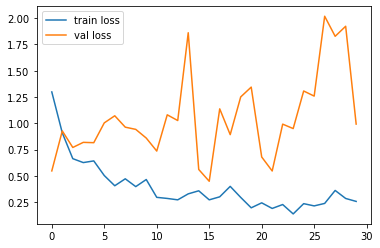

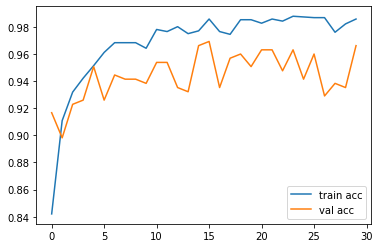

<Figure size 432x288 with 0 Axes>

In [23]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')